# Autoencoders

In [2]:
# Autoreloading makes development easier
%load_ext autoreload
%autoreload 2

In [3]:
# Import libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as krs
import tensorflow_probability as tfp
import json
from sklearn.model_selection import train_test_split
from tools.audio_tools import read_audio, write_audio, play_audio
from tools.feature_tools import compute_mels, compute_imels, compute_mfcc, compute_imfcc, load_data, normalize_features, denormalize_features
from tools.constants import cut_classical_path, cut_jazz_path, models_path
from tools.plot_tools import make_figax, plot_history, plot_audio, plot_spectral_feature
from tools.tensorflow_tools import tune_hyperparameters

## Data Loading

### Load Audio & Extract Features

In [5]:
# Load samples from both styles
n_samples = 5000
X_classical_raw = load_data(cut_classical_path, n_samples=n_samples)
X_jazz_raw = load_data(cut_jazz_path, n_samples=n_samples)

# Concatenate (train on all samples)
X_raw = np.concatenate((X_classical_raw, X_jazz_raw))

# Print feature shape
print(f"{X_raw.shape = }")

100 %
100 %
X_raw.shape = (1019, 67, 128, 1)


### Train - Validation - Test Split

In [6]:
# Fraction of data to keep apart for validation
test_size = round(0.1 * len(X_raw))
val_size = test_size
# Perform split
X_raw_train, X_raw_test = train_test_split(X_raw, test_size=test_size)
X_raw_train, X_raw_val = train_test_split(X_raw_train, test_size=val_size)
# Verify split shapes
print(f"{X_raw_train.shape = }")
print(f"{X_raw_test.shape = }")
print(f"{X_raw_val.shape = }")

X_raw_train.shape = (815, 67, 128, 1)
X_raw_test.shape = (102, 67, 128, 1)
X_raw_val.shape = (102, 67, 128, 1)


In [7]:
input_shape = X_raw_train.shape[1:]
print(f"{input_shape = }")

input_shape = (67, 128, 1)


### Normalize Features

In [8]:
# Perform normalization
X_train, X_val, X_test = normalize_features(X_raw_train, X_raw_val=X_raw_val, X_raw_test=X_raw_test)

print(f"{X_train.shape = }")
print(f"{X_val.shape = }")
print(f"{X_test.shape = }")

X_train.shape = (815, 67, 128, 1)
X_val.shape = (102, 67, 128, 1)
X_test.shape = (102, 67, 128, 1)


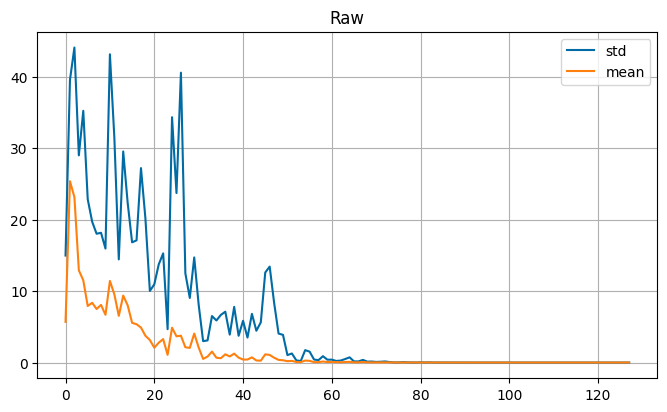

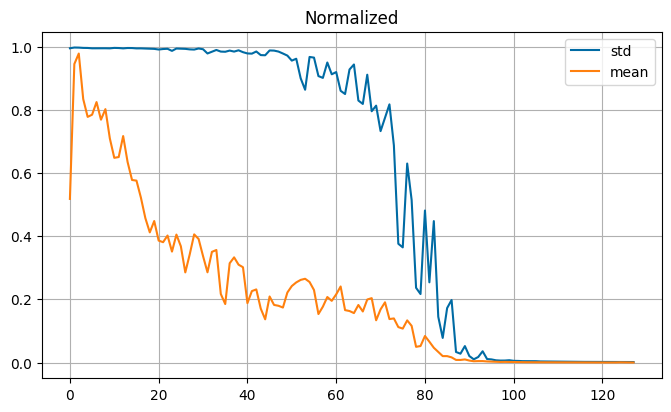

In [9]:
# See the effect of normalization
fig, ax = make_figax()
ax.plot(np.std(X_raw_train, axis=(0,1,3)), label="std")
ax.plot(np.mean(X_raw_train, axis=(0,1,3)), label="mean")
#ax.plot(np.max(X_raw_train, axis=(0,1,3)), label="max")
ax.grid()
ax.legend()
ax.set_title("Raw")
plt.show()


fig, ax = make_figax()
ax.plot(np.std(X_train, axis=(0,1,3)), label="std")
ax.plot(np.mean(X_train, axis=(0,1,3)), label="mean")
#ax.plot(np.max(X_train, axis=(0,1,3)), label="max")
ax.grid()
ax.legend()
ax.set_title("Normalized")
plt.show()

## Autoencoders

### Test Script

In [10]:
nop = lambda x: x

def test_autoencoder(autoencoder, test_set = X_test, plot_transforms = True, plot_raw_transforms = True, plot_waveforms = True):
  # Pick sample at random
  print("Picking Sample")
  choice = np.random.choice(len(test_set))
  x = test_set[choice]

  # Autencoder
  print("Autencoding")
  x_hat = np.array(autoencoder(x.reshape((1, *x.shape))))

  if plot_transforms:
    print("Plotting transforms")
    fig, ax = plot_spectral_feature(x, fn=nop)
    ax.set_title("Original Preprocessed Spectrum")
    fig, ax = plot_spectral_feature(x_hat, fn=nop)
    ax.set_title("Reconstructed Preprocessed Spectrum")
    plt.show()

  # Postprocess
  print("Postprocessing")
  x_raw = denormalize_features(x.reshape((1, *x.shape)))[0]
  x_raw_hat = denormalize_features(x_hat.reshape((1, *x.shape)))[0]

  if plot_raw_transforms:
    print("Plotting transforms")
    fig, ax = plot_spectral_feature(x_raw)
    ax.set_title("Original Raw Spectrum")
    fig, ax = plot_spectral_feature(x_raw_hat)
    ax.set_title("Reconstructed Raw Spectrum")
    plt.show()

  # Reconstruct Audio
  print("Reconstructing Audio")
  s = np.squeeze(compute_imels(x_raw))
  s_hat = np.squeeze(compute_imels(x_raw_hat))

  if plot_waveforms:
    fig, ax = plot_audio(s)
    ax.set_title("Original Waveform")
    fig, ax = plot_audio(s_hat)
    ax.set_title("Reconstructed Waveform")
    plt.show()

  # Play audio
  print("Original Audio")
  player = play_audio(s)
  print("Reconstructed Audio")
  player = play_audio(s_hat)
  print()

In [11]:
def free_memory(autoencoder):
  krs.backend.clear_session()
  del autoencoder.encoder
  del autoencoder.decoder
  del autoencoder
  krs.backend.clear_session()

In [12]:
os.makedirs(models_path, exist_ok = True)
def save_autoencoder(autoencoder, params, history, name):
    # Define and make directory
    autoencoder_path = os.path.join(models_path, name)
    os.makedirs(autoencoder_path, exist_ok = True)
    
    # Save parameters
    with open(os.path.join(autoencoder_path, "params.json"), "w") as params_file:
        json.dump(params, params_file)
        
    # Save history
    with open(os.path.join(autoencoder_path, "history.json"), "w") as history_file:
        if not isinstance(history, dict):
            history = history.history
        json.dump(history, history_file)
    
    # Save model
    autoencoder.save(os.path.join(autoencoder_path, "model.keras"))

def load_autoencoder(name, load_model = True):
    # Define path
    autoencoder_path = os.path.join(models_path, name)
    
    # Load parameters
    with open(os.path.join(autoencoder_path, "params.json"), "r") as params_file:
        params = json.load(params_file)
    
    # Load history
    with open(os.path.join(autoencoder_path, "history.json"), "r") as history_file:
        history = json.load(history_file)
    
    # Load model
    autoencoder = None
    if load_model:
        autoencoder = krs.models.load_model(os.path.join(autoencoder_path, "model.keras"))
    
    return autoencoder, params, history

### Convolutional Autoencoder

In [13]:
from models.autoencoders import Conv2DAutoencoder

In [14]:
default_params = {
    "feature_shape": input_shape,
    "compression": 8,
    "kernel_size": 3,
    "conv_depth": 1,
    "input_chans_multiplier": 1,
    "skip_connection": True,
    "pooling_type": "average",
}

compile_kwargs = {
    "optimizer": "adam",
    "loss": "mae",
}


In [15]:
# Test training
autoencoder = Conv2DAutoencoder(**default_params)
autoencoder.compile(**compile_kwargs)
history = autoencoder.fit(X_train, X_train, epochs=10, shuffle=True, validation_data=(X_val, X_val), verbose=1)

Epoch 1/10
26/26 [==============================] - 3s 58ms/step - loss: 1.0036 - val_loss: 0.5121
Epoch 2/10
26/26 [==============================] - 1s 42ms/step - loss: 0.3935 - val_loss: 0.3404
Epoch 3/10
26/26 [==============================] - 1s 43ms/step - loss: 0.3059 - val_loss: 0.3015
Epoch 4/10
26/26 [==============================] - 1s 43ms/step - loss: 0.2794 - val_loss: 0.2825
Epoch 5/10
26/26 [==============================] - 1s 41ms/step - loss: 0.2644 - val_loss: 0.2699
Epoch 6/10
26/26 [==============================] - 1s 42ms/step - loss: 0.2538 - val_loss: 0.2607
Epoch 7/10
26/26 [==============================] - 1s 41ms/step - loss: 0.2457 - val_loss: 0.2533
Epoch 8/10
26/26 [==============================] - 1s 40ms/step - loss: 0.2392 - val_loss: 0.2472
Epoch 9/10
26/26 [==============================] - 1s 41ms/step - loss: 0.2337 - val_loss: 0.2421
Epoch 10/10
26/26 [==============================] - 1s 42ms/step - loss: 0.2291 - val_loss: 0.2377


In [34]:
# Hyperparameter tuning
results_path = os.path.join("./results/Conv2DAutoencoder")
os.makedirs(results_path, exist_ok=True)
keys = np.array([
    "input_chans_multiplier",
    "conv_depth",
    "skip_connection",
    "kernel_size",
    "pooling_type",
])
vals = np.array([
    [1, 2, 4, 8],
    [1, 2, 3],
    [True, False],
    [3, 5],
    ["max", "average"],
], dtype="object")
loss_key = "val_loss"
epochs = 1
passes = 5

In [35]:
# Random optimization
optimal_params, optimal_loss = tune_hyperparameters(
    X_train,
    X_train,
    Conv2DAutoencoder,
    default_params,
    keys,
    vals,
    loss_key,
    X_val=X_val,
    y_val=X_val,
    results_path=results_path,
    epochs=epochs,
    compile_kwargs=compile_kwargs,
    verbose=True,
    do_random=True,
    random_attempts=3,
)

Optimizing for default parameters
21/26 [=======================>......] - ETA: 0s - loss: 3.3833

KeyboardInterrupt: 

In [36]:
print(f"{optimal_params = }")
print(f"{optimal_loss = }")

optimal_params = {'feature_shape': (67, 128, 1), 'compression': 8, 'kernel_size': 5, 'conv_depth': 3, 'input_chans_multiplier': 4, 'skip_connection': False, 'pooling_type': 'max'}
optimal_loss = 0.22391708195209503


In [37]:
# Sequential optimization
for i in range(passes):
    # Random optimization
    permutation = np.random.permutation(len(keys))
    optimal_params, optimal_loss = tune_hyperparameters(
        X_train,
        X_train,
        Conv2DAutoencoder,
        optimal_params,
        keys[permutation],
        vals[permutation],
        loss_key,
        X_val=X_val,
        y_val=X_val,
        results_path=results_path,
        epochs=epochs,
        compile_kwargs=compile_kwargs,
        verbose=True,
        do_random=False,
    )

Training model for skip_connection = True


KeyboardInterrupt: 

### Variational Autencoder

In [38]:
from models.autoencoders import VariationalAutoencoder

In [39]:
try:
    default_params = optimal_params.copy()
    default_params["kl_reg"] = 1
except:
    print("WARNING: Optimal params are undefined")
    default_params = {
        "feature_shape": input_shape,
        "compression": 8,
        "kernel_size": 3,
        "conv_depth": 1,
        "input_chans_multiplier": 1,
        "skip_connection": True,
        "pooling_type": "average",
        "kl_reg": 1,
    }

In [40]:
autoencoder = VariationalAutoencoder(**default_params)
autoencoder.compile(optimizer="adam")
history = autoencoder.fit(X_train, X_train, epochs=10, shuffle=True, validation_data=(X_val, X_val), verbose=1)

Epoch 1/10
26/26 [==============================] - 34s 1s/step - loss: 0.5303 - r_loss: 0.2086 - kl_loss: 0.3218 - val_loss: 0.6785 - val_r_loss: 0.2267 - val_kl_loss: 0.4518
Epoch 2/10
26/26 [==============================] - 26s 996ms/step - loss: 0.5323 - r_loss: 0.2083 - kl_loss: 0.3241 - val_loss: 0.6768 - val_r_loss: 0.2255 - val_kl_loss: 0.4513
Epoch 3/10
26/26 [==============================] - 26s 1s/step - loss: 0.5292 - r_loss: 0.2044 - kl_loss: 0.3248 - val_loss: 0.6754 - val_r_loss: 0.2239 - val_kl_loss: 0.4515
Epoch 4/10
26/26 [==============================] - 26s 986ms/step - loss: 0.5278 - r_loss: 0.2040 - kl_loss: 0.3238 - val_loss: 0.6760 - val_r_loss: 0.2247 - val_kl_loss: 0.4512
Epoch 5/10
26/26 [==============================] - 25s 966ms/step - loss: 0.5231 - r_loss: 0.2016 - kl_loss: 0.3215 - val_loss: 0.6747 - val_r_loss: 0.2230 - val_kl_loss: 0.4516
Epoch 6/10
17/26 [==================>...........] - ETA: 8s - loss: 0.5217 - r_loss: 0.2019 - kl_loss: 0.3198

KeyboardInterrupt: 

In [41]:
# Hyperparameter tuning
results_path = os.path.join("./results/Conv2DAutoencoder")
os.makedirs(results_path, exist_ok=True)
keys = np.array([
    "kl_reg",
])
vals = np.array([
    [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
], dtype="object")
loss_key="val_r_loss"
epochs = 100
passes = 1
optimal_params = default_params.copy()

In [42]:
# Sequential optimization
for i in range(passes):
    # Random optimization
    permutation = np.random.permutation(len(keys))
    optimal_params, optimal_loss = tune_hyperparameters(
        X_train,
        X_train,
        VariationalAutoencoder,
        optimal_params,
        keys[permutation],
        vals[permutation],
        loss_key,
        X_val=X_val,
        y_val=X_val,
        results_path=results_path,
        epochs=epochs,
        compile_kwargs=compile_kwargs,
        verbose=True,
        do_random=False,
    )

Training model for kl_reg = 1


KeyboardInterrupt: 

Picking Sample
Autencoding
Plotting transforms


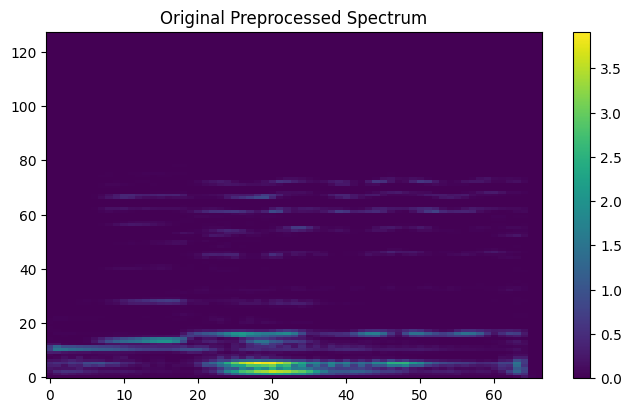

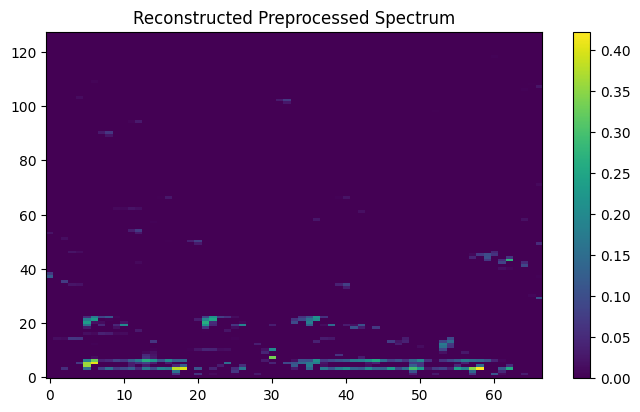

Postprocessing
Plotting transforms


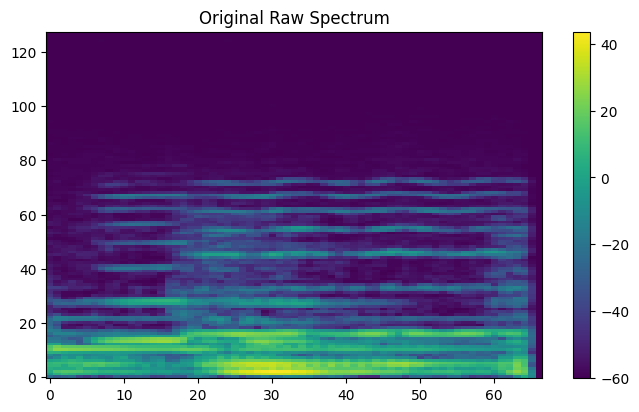

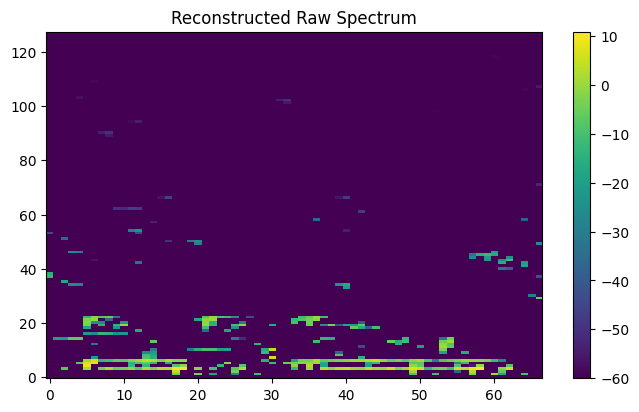

Reconstructing Audio


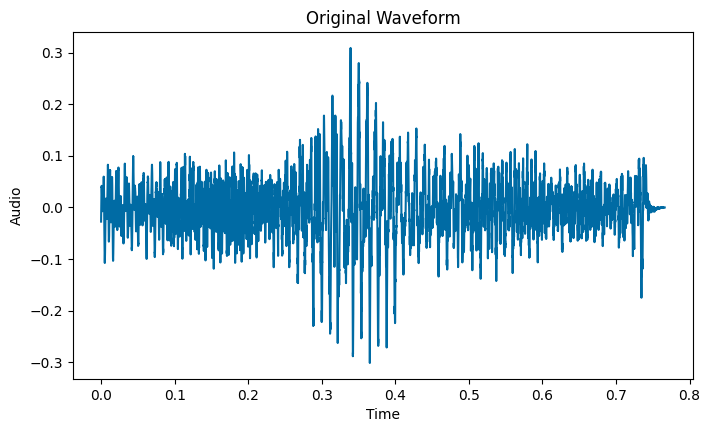

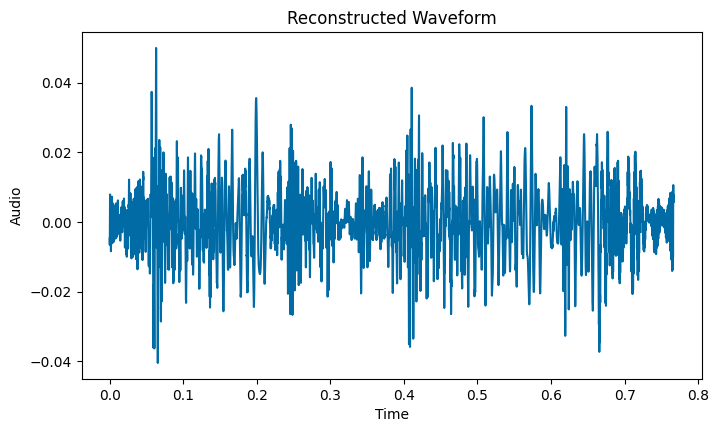

Original Audio


Reconstructed Audio


In [50]:
test_autoencoder(autoencoder)

### GAN Autoencoder

In [85]:
from models.autoencoders import GANGenerator, GANDiscriminator, GAN

In [103]:
compression = 8
kernel_size = 3
conv_depth = 1
input_chans_multiplier = 1
skip_connection = False
pooling_type = "average"
gan_reg = 1.
c_reg = 1.
s_reg = 1.
mlp_layers = 2

generator = GANGenerator(
    input_shape,
    compression,
    kernel_size,
    conv_depth,
    input_chans_multiplier=input_chans_multiplier,
    skip_connection=skip_connection,
    pooling_type=pooling_type,
    gan_reg=gan_reg,
    c_reg = c_reg,
    s_reg=s_reg,
)

discriminator = GANDiscriminator(
    input_shape,
    mlp_layers,
    compression,
    kernel_size,
)

mlp_hidden_dims = array([33])


In [104]:
gan = GAN(generator, discriminator)

In [105]:
gan.compile("adam", "adam")

In [106]:
history = gan.fit(X_train, X_train, epochs=25, shuffle=True, verbose=1)

Epoch 1/25
29/29 [==============================] - 9s 140ms/step - loss: 3.4113 - r_loss: 0.2124 - gan_loss: 2.3951 - c_loss: 0.0040 - s_loss: 0.7999 - d_loss: 0.5360
Epoch 2/25
29/29 [==============================] - 4s 142ms/step - loss: 4.9334 - r_loss: 0.2155 - gan_loss: 3.9216 - c_loss: 0.0013 - s_loss: 0.7950 - d_loss: 0.0120
Epoch 3/25
29/29 [==============================] - 4s 141ms/step - loss: 4.8140 - r_loss: 0.2159 - gan_loss: 3.7928 - c_loss: 0.0015 - s_loss: 0.8038 - d_loss: 0.0324
Epoch 4/25
29/29 [==============================] - 4s 141ms/step - loss: 2.9775 - r_loss: 0.2716 - gan_loss: 1.6819 - c_loss: 0.0015 - s_loss: 1.0225 - d_loss: 0.7128
Epoch 5/25
29/29 [==============================] - 4s 145ms/step - loss: 4.1508 - r_loss: 0.2637 - gan_loss: 3.0819 - c_loss: 0.0010 - s_loss: 0.8042 - d_loss: 0.2085
Epoch 6/25
29/29 [==============================] - 5s 161ms/step - loss: 2.2771 - r_loss: 0.2158 - gan_loss: 1.2585 - c_loss: 5.0700e-04 - s_loss: 0.8023 - d_l